# 1. Predicting CCS Concepts

RQ1: Can  we  use  a  supervised  learning  algorithm  to predict the CCS concepts of a research submission using textual information in the submission?

**Importing libraries and external dependencies**

In [20]:
# Runs on Colab, locally with python 3.x
#  Required for preprocessing
!pip install num2words
# Required for certain visualizations
!pip install pyLDAvis 

# uncomment if you want to do data processing. Pickled files have been attached so there is no need.
# !pip install progressbar
# !pip install pdftotext
# import pdftotext
# from progressbar import ProgressBar

import os
from os import listdir
from os.path import isfile, join
import re
import pickle

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from num2words import num2words

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score


from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

import string
import numpy as np
import copy
import pandas as pd
import math
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 


from gensim.models import HdpModel
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import CoherenceModel
from gensim.models import LdaModel

import torch
import torch.nn as nn
import torch.nn.functional as F


import pyLDAvis.gensim
import pickle 
import pyLDAvis

import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

Preprocessing and Visualizer Functions

In [21]:
def convert_lower_case(data):
    return np.char.lower(data)

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

def lemmatizing(data):
    lemmatizer = WordNetLemmatizer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemmatizer.lemmatize(w)
    return new_text

def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text


def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = lemmatizing(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = remove_punctuation(data) 
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one
    return data

def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return c

def topics(lda_model):

    for n, topic in enumerate(lda_model.show_topics(num_topics=30, num_words=10, log=False, formatted=False)):
    	print ('Topic %d:' % (n+1))
    	for pair in list(topic[1]):
    		word = pair[0]
    		prob = pair[1]
    		print ('\t%6.5f %-22s' % (prob, word))
    	print
        
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

**Reading resesrch papers from various conferences**

In [22]:
path = os.getcwd()+"/papers/all"

In [23]:
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

In [24]:
file_number = len(onlyfiles)
print("Total number of papers:", file_number)

Total number of papers: 486


In [25]:
ccs_concepts = []
topics = []
list_of_topics = []
processed_texts = [] 
general_papers = []
articles = []
bag_of_words = []

pbar = ProgressBar()
for i in pbar(onlyfiles):
    addr = path+"/"+i
    file_name = i
    if addr[-3:]=="pdf":
        with open(addr, "rb") as f:
            pdf = pdftotext.PDF(f)
            text = ("\n".join(pdf)).split("\n")
            paper = ("\n".join(pdf))
            tokens = (word_tokenize(preprocess("\n".join(pdf))))
            processed_texts.append(tokens)
            ccs_concepts_paper = []
            topics_paper = []
            for i in text:
                line = (i.split("              "))
                for i in line:
                    if ' → ' in line[0]:
                        ccs_concept_line = line[0].split(' → ')
                        if '•' in ccs_concept_line[0]:
                            topic = (ccs_concept_line[0].split('•')[1]).lower().strip().rstrip()
                            topic = topic.replace('-', ' ')
                            topic = re.sub(' +', ' ', topic)
                            topic = re.sub(r'\([^)]*\)', '', topic)
                            topic = ' '.join(topic.split())
                            topics_paper.append(topic)
                            if topic not in list_of_topics:
                                list_of_topics.append(topic)
                            ccs_concepts_paper.append(ccs_concept_line)
                            general_papers.append(paper)
                            bag_of_words.append(word_tokenize(preprocess(paper)))
            topics_paper = set(topics_paper)
            topics.append([file_name,topics_paper])
            articles.append(paper)
            ccs_concepts.append([file_name,ccs_concepts_paper])

100% |########################################################################|


**Pickling Data**

In [26]:
# with open("articles.txt", "wb") as fp:
#     pickle.dump(articles, fp)

# with open("processed_texts.txt", "wb") as fp:
#     pickle.dump(processed_texts, fp)
    
# with open("general_papers.txt", "wb") as fp:
#     pickle.dump(general_papers, fp)
    
# with open("bag_of_words.txt", "wb") as fp:
#     pickle.dump(bag_of_words, fp)
    
# with open("ccs_concepts.txt", "wb") as fp:
#     pickle.dump(ccs_concepts, fp)
    
# with open("topics.txt", "wb") as fp:
#     pickle.dump(topics, fp)

# with open("list_of_topics.txt", "wb") as fp:
#     pickle.dump(list_of_topics, fp)   

**Unpickling Data**

In [27]:
with open("articles.txt", "rb") as fp:   
    articles = pickle.load(fp)
    
with open("processed_texts.txt", "rb") as fp:   
    processed_texts = pickle.load(fp)

with open("general_papers.txt", "rb") as fp:   
    general_papers = pickle.load(fp)
    
with open("bag_of_words.txt", "rb") as fp:   
    bag_of_words = pickle.load(fp)
    
with open("ccs_concepts.txt", "rb") as fp:   
    ccs_concepts = pickle.load(fp)
    
with open("topics.txt", "rb") as fp:   
    topics = pickle.load(fp)
    
with open("list_of_topics.txt", "rb") as fp:   
    list_of_topics = pickle.load(fp)

**Generating TF-IDF Vectors**

In [28]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(articles)
f_array = (X.toarray())

Alternative TF-IDF Calculation method

In [29]:
DF = {}

for i in range(len(processed_texts)):
    tokens = processed_texts[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}
for i in DF:
    DF[i] = len(DF[i])

In [30]:
doc = 0
tf_idf = {}
for i in range(len(processed_texts)):
    N = len(processed_texts)
    tokens = processed_texts[i]
    
    counter = Counter(tokens)
    words_count = len(tokens)
    
    for token in np.unique(tokens):
        
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = np.log((N+1)/(df+1))
        
        tf_idf[doc, token] = tf*idf

    doc += 1

In [31]:
total_vocab_size = len(DF)
D = np.zeros((N, total_vocab_size))
for i in tf_idf:
    try:
        ind = total_vocab.index(i[1])
        D[i[0]][ind] = tf_idf[i]
    except:
        pass

**Generating LDA and HDP Models**

In [32]:
# Optimized after experimentation
TOPIC_NUM  = 12 
LDA = 'Project.%03d.lda' % TOPIC_NUM

In [33]:
print ('Building dictionary of terms ...')
dictionary = Dictionary(bag_of_words)
print("Size of dictionary:",len(dictionary))
print ('Filtering too frequent and infrequent terms ...')
dictionary.filter_extremes(no_below=3)
dictionary.filter_extremes(no_above = 0.8)
print("Size of dictionary:",len(dictionary))
print ('Saving dictionary...')
dictionary.save('PS3.bow.dict')
print( 'Building bag-of-words corpus ...')
bow_corpus = [ dictionary.doc2bow(t) for t in bag_of_words ]
print("Size of bag of words corpus:",len(bow_corpus))
print( 'Serializing corpus')
MmCorpus.serialize('PS3.bow.mm', bow_corpus)
print( 'Splitting Data into testing and training datasets')
size = int(len(bow_corpus) * 9 / 10)
training = bow_corpus[:size]
testing = bow_corpus[size:]
print( 'Training LDA w/ %d topics on first %d texts ...' % (TOPIC_NUM, len(training)))
lda = LdaModel(training, id2word=dictionary, num_topics=TOPIC_NUM, passes=5)
hdp = HdpModel(training, dictionary)
print( 'Saving LDA model')
lda.save(LDA)

Building dictionary of terms ...
Size of dictionary: 74866
Filtering too frequent and infrequent terms ...
Size of dictionary: 35077
Saving dictionary...
Building bag-of-words corpus ...
Size of bag of words corpus: 1100
Serializing corpus
Splitting Data into testing and training datasets
Training LDA w/ 12 topics on first 990 texts ...
Saving LDA model


**Linguistic Analysis**

In [34]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, training, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.052793 -0.093730       1        1  12.986030
6     -0.134295  0.129086       2        1  10.748487
1      0.159419  0.073769       3        1   9.780869
7      0.047221 -0.018530       4        1   8.670765
8     -0.011413 -0.018731       5        1   7.977776
9      0.078455  0.026924       6        1   7.834265
4      0.025175 -0.007804       7        1   7.741953
3     -0.056985 -0.127050       8        1   7.112180
10     0.048243 -0.015966       9        1   6.981799
2     -0.021869  0.014788      10        1   6.885991
5      0.003438 -0.041156      11        1   6.654164
11    -0.084595  0.078401      12        1   6.625716, topic_info=             Term         Freq        Total Category  logprob  loglift
2030  participant  8564.000000  8564.000000  Default  30.0000  30.0000
934        packet  8491.000000  8491.000000  Default  29.0000  29.0000
3085        cache  6276.000000  6276.000000  Default  28.0000  28.0000
1447         word  4582.000000  4582.000000  Default  27.0000  27.0000
905        object  7794.000000  7794.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
938      parallel   535.368347  3996.024658  Topic12  -6.0261   0.7041
1870  interaction   536.061218  4210.872070  Topic12  -6.0249   0.6530
816        matrix   546.260925  5714.542969  Topic12  -6.0060   0.3665
763           let   524.659607  4452.408691  Topic12  -6.0463   0.5758
2628        index   468.514496  2255.466797  Topic12  -6.1595   1.1427

[1018 rows x 6 columns], token_table=       Topic      Freq Term
term                       
25827      1  0.009510  ȃ
25827      2  0.009510  ȃ
25827      4  0.009510  ȃ
25827      6  0.009510  ȃ
25827      8  0.028530  ȃ
...      ...       ...  ...
26746      4  0.008005   𝜃®
26746      5  0.008005   𝜃®
26746      8  0.008005   𝜃®
26746      9  0.008005   𝜃®
32573     11  0.923077   𝜇s

[8322 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 2, 8, 9, 10, 5, 4, 11, 3, 6, 12])

**Storing Data in a dataframe**

In [35]:
data = []
size_hdp = 0
for index, i in enumerate(topics[:-1]):
    toks = processed_texts[index]
    bow_corpus = dictionary.doc2bow(toks)
    doc_lda = lda[bow_corpus]
    doc_hdp = hdp[bow_corpus]
    max_index = 12
    missing_values = []
    for j in range(0, max_index + 1):
        missing = False
        for index, val in doc_lda:
            if j != index:
                missing = True
            else:
                missing = False
                break
        if missing:
            missing_values.append((j,0))

    lda_feature_vector = doc_lda + missing_values
    lda_feature_vector_sorted = sorted(lda_feature_vector, key=lambda x:x[0])
    lda_feature_vector_sorted = [a_tuple[1] for a_tuple in lda_feature_vector_sorted]
    
    max_index = 148
    missing_values = []
    for j in range(0, max_index + 1):
        missing = False
        for index, val in doc_hdp:
            if j != index:
                missing = True
            else:
                missing = False
                break
        if missing:
            missing_values.append((j,0))

    hdp_feature_vector = doc_hdp + missing_values
    hdp_feature_vector_sorted = sorted(hdp_feature_vector, key=lambda x:x[0])
    if size_hdp < hdp_feature_vector_sorted[-1][0]:
        size_hdp = hdp_feature_vector_sorted[-1][0]
    hdp_feature_vector_sorted = [a_tuple[1] for a_tuple in hdp_feature_vector_sorted]
    
    if list(i[1:][0]):
        word_vector = f_array[index].reshape((1,-1))
        if len(list(i[1:][0])) == 1:
            topic1 = preprocess(list(i[1:][0])[0])
            data.append({'Paper':i[0],'Topic1':topic1,'LDA_topics': lda_feature_vector_sorted,'HDP_topics':hdp_feature_vector_sorted,'word_vector':word_vector})
        elif len(list(i[1:][0])) == 2:
            topic1 = preprocess(list(i[1:][0])[0])
            topic2 = preprocess(list(i[1:][0])[1])
            data.append({'Paper':i[0],'Topic1':topic1,'Topic2':topic2,'LDA_topics':lda_feature_vector_sorted,'HDP_topics':hdp_feature_vector_sorted,'word_vector':word_vector})
        elif len(list(i[1:][0])) == 3:
            topic1 = preprocess(list(i[1:][0])[0])
            topic2 = preprocess(list(i[1:][0])[1])
            topic3 = preprocess(list(i[1:][0])[2])
            data.append({'Paper':i[0],'Topic1':topic1,'Topic2':topic2,'Topic3':topic3,'LDA_topics':lda_feature_vector_sorted,'HDP_topics':hdp_feature_vector_sorted,'word_vector':word_vector})
df = pd.DataFrame (data, columns = ['Paper','Topic1','Topic2','Topic3','LDA_topics','HDP_topics','word_vector'])
vc = df['Topic1'].value_counts()
u  = [i not in set(vc[vc<=3].index) for i in df['Topic1']]
df = df[u]

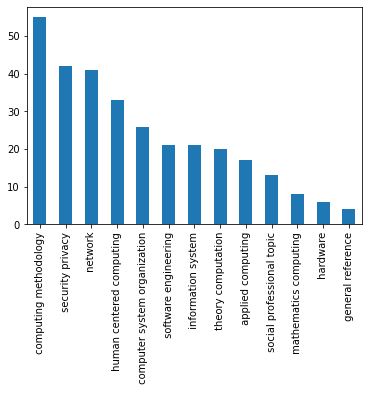

In [37]:
df['Topic1'].value_counts().plot(kind='bar')

## TF-IDF-based Model

Training Neural Network model using sklearn.neural_network.MLPClassifier

**Alpha** is the L2 penalty (regularization term) parameter

**Tolerance** for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to ‘adaptive’, convergence is considered to be reached and training stops.

In [38]:
X = (np.vstack(df['word_vector']))
y = (np.vstack(df['Topic1'])).ravel()
x_train1, x_test1, y_train1, y_test1 = train_test_split(X,y, test_size=0.3,random_state=1)

NNmodel = MLPClassifier(alpha=.1, early_stopping=False, tol=.00001)
NNmodel.fit(x_train1, y_train1)

y_pred = NNmodel.predict(x_test1)
cmtx = pd.DataFrame(
    confusion_matrix(y_test1, y_pred, labels=NNmodel.classes_), 
    index=NNmodel.classes_, 
)
print(cmtx)
print("Accuracy: ",accuracy_score(y_test1, y_pred, normalize=False)," out of ",len(y_test1))
print("Precision: ",precision_score(y_test1, y_pred, zero_division=1, average='macro'))
print("Recall: ",recall_score(y_test1, y_pred,zero_division=1, average='macro'))
print("F1: ",f1_score(y_test1, y_pred, zero_division=1,average='macro'))
TASK1_TFIDF = 'TASK1_TF-IDF.sav'
pickle.dump(NNmodel, open(TASK1_TFIDF, 'wb'))

                               0  1  2  3  4  5  6  7  8  9  10  11  12
 applied computing             0  0  3  0  0  0  1  0  0  0   0   0   0
 computer system organization  0  2  1  0  0  0  0  1  1  0   0   1   0
 computing methodology         1  0  6  0  0  1  1  5  1  0   2   2   1
 general reference             0  0  0  0  0  1  0  1  0  0   0   0   0
 hardware                      0  0  1  0  0  0  0  0  0  0   0   0   0
 human centered computing      0  0  4  0  0  6  1  0  0  0   0   0   0
 information system            0  0  0  0  0  0  4  0  1  0   0   1   0
 mathematics computing         0  0  0  0  0  0  0  0  0  0   0   0   0
 network                       0  3  1  0  0  0  1  0  7  1   0   0   0
 security privacy              0  0  2  0  0  1  1  2  0  7   2   1   1
 social professional topic     0  0  2  0  0  1  0  0  0  0   0   0   0
 software engineering          0  0  0  0  0  1  0  0  0  0   1   2   0
 theory computation            1  0  2  0  0  0  0  1  0  1   0 

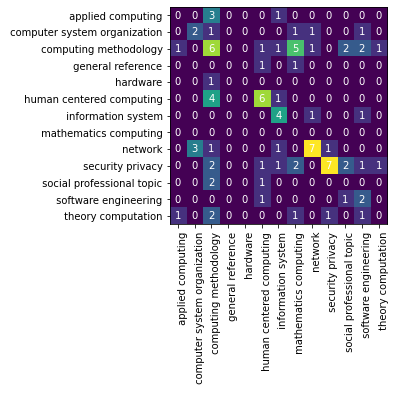

<Figure size 432x288 with 0 Axes>

In [39]:
cm = confusion_matrix(y_test1, y_pred, labels=NNmodel.classes_)
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(len(NNmodel.classes_)))
ax.set_yticks(np.arange(len(NNmodel.classes_)))
ax.set_xticklabels(NNmodel.classes_)
ax.set_yticklabels(NNmodel.classes_)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
for i in range(len(NNmodel.classes_)):
    for j in range(len(NNmodel.classes_)):
        text = ax.text(j, i, cm[i,j],
                       ha="center", va="center", color="w")
plt.show()
plt.savefig('TF-IDF.png')

## LDA-based Model

In [40]:
X = (np.vstack(df['LDA_topics']))
y = (np.vstack(df['Topic1'])).ravel()
x_train2, x_test2, y_train2, y_test2 = train_test_split(X,y, test_size=0.3,random_state=1)
NNmodel = MLPClassifier(alpha=.1, early_stopping=False, tol=.00001)
NNmodel.fit(x_train2, y_train2)
y_pred = NNmodel.predict(x_test2)
cmtx = pd.DataFrame(
    confusion_matrix(y_test2, y_pred, labels=NNmodel.classes_), 
    index=NNmodel.classes_, 
)
print(cmtx)
print("Accuracy: ",accuracy_score(y_test2, y_pred, normalize=False)," out of ",len(y_test2))
print("Precision: ",precision_score(y_test2, y_pred, zero_division=1, average='macro'))
print("Recall: ",recall_score(y_test2, y_pred,zero_division=1, average='macro'))
print("F1: ",f1_score(y_test2, y_pred, zero_division=1,average='macro'))
TASK1_LDA = 'TASK1_LDA.sav'
pickle.dump(NNmodel, open(TASK1_LDA, 'wb'))

                               0  1  2  3  4  5  6  7  8  9  10  11  12
 applied computing             0  0  1  0  0  2  0  0  0  0   0   0   1
 computer system organization  0  3  2  0  0  0  0  0  1  0   0   0   0
 computing methodology         0  1  9  0  0  5  0  0  1  1   1   0   2
 general reference             0  0  2  0  0  0  0  0  0  0   0   0   0
 hardware                      0  0  1  0  0  0  0  0  0  0   0   0   0
 human centered computing      0  0  3  0  0  6  0  0  0  1   0   0   1
 information system            0  1  3  0  0  0  0  0  0  1   0   0   1
 mathematics computing         0  0  0  0  0  0  0  0  0  0   0   0   0
 network                       0  1  2  0  0  0  0  0  9  0   1   0   0
 security privacy              0  0  5  0  0  1  0  0  4  2   2   0   3
 social professional topic     0  0  0  0  0  2  0  0  0  0   1   0   0
 software engineering          0  0  2  0  0  0  0  0  1  0   0   1   0
 theory computation            0  1  2  0  0  0  0  0  0  0   0 

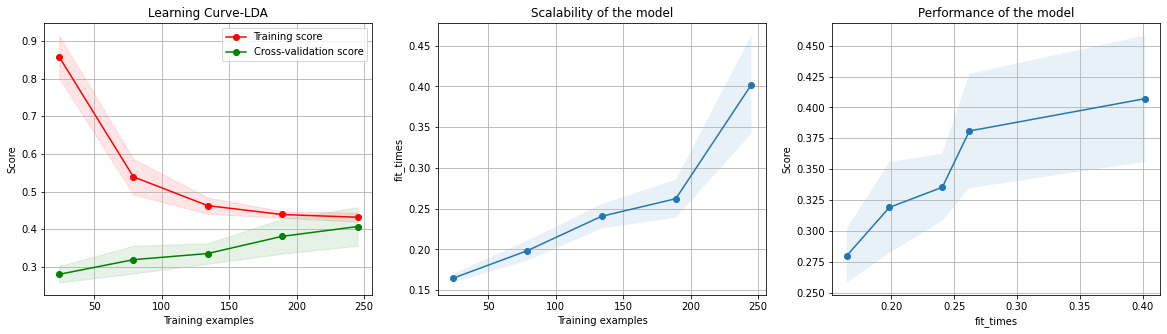

In [41]:
plot_learning_curve(NNmodel, "Learning Curve-LDA", X, y, n_jobs=4)

plt.show()

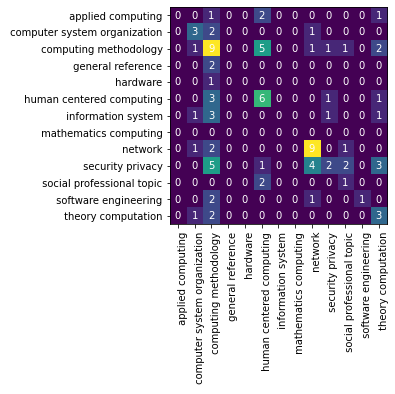

<Figure size 432x288 with 0 Axes>

In [42]:
cm = confusion_matrix(y_test2, y_pred, labels=NNmodel.classes_)
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(len(NNmodel.classes_)))
ax.set_yticks(np.arange(len(NNmodel.classes_)))
ax.set_xticklabels(NNmodel.classes_)
ax.set_yticklabels(NNmodel.classes_)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
for i in range(len(NNmodel.classes_)):
    for j in range(len(NNmodel.classes_)):
        text = ax.text(j, i, cm[i,j],
                       ha="center", va="center", color="w")
plt.show()
plt.savefig('LDA.png')

## HDP-based Model


HDP uses a Dirichlet process to capture the uncertainty in the number of topics. 

A common base distribution is selected which represents the countably-infinite set of possible topics for the corpus, and then the finite distribution of topics for each document is sampled from this base distribution.

HDP has the advantage that the maximum number of topics can be unbounded and learned from the data rather than specified in advance. 

In [43]:
X = (np.vstack(df['HDP_topics']))
y = (np.vstack(df['Topic1'])).ravel()
x_train3, x_test3, y_train3, y_test3 = train_test_split(X,y, test_size=0.3,random_state=1)
NNmodel = MLPClassifier(alpha=.1, early_stopping=False, tol=.00001)
NNmodel.fit(x_train3, y_train3)
y_pred = NNmodel.predict(x_test3)
cmtx = pd.DataFrame(
    confusion_matrix(y_test3, y_pred, labels=NNmodel.classes_), 
    index=NNmodel.classes_, 
)
print(cmtx)
print("Accuracy: ",accuracy_score(y_test3, y_pred, normalize=False)," out of ",len(y_test3))
print("Precision: ",precision_score(y_test3, y_pred, zero_division=1, average='macro'))
print("Recall: ",recall_score(y_test3, y_pred,zero_division=1, average='macro'))
print("F1: ",f1_score(y_test3, y_pred, zero_division=1,average='macro'))
TASK1_HDP = 'TASK1_HDP.sav'
pickle.dump(NNmodel, open(TASK1_HDP, 'wb'))

                               0  1  2  3  4  5  6  7   8  9  10  11  12
 applied computing             0  0  3  0  0  0  0  0   0  0   0   1   0
 computer system organization  0  0  1  0  0  0  0  0   4  0   0   1   0
 computing methodology         0  0  8  0  0  2  1  0   4  0   0   4   1
 general reference             0  0  1  0  0  0  0  0   0  0   0   1   0
 hardware                      0  0  0  0  0  1  0  0   0  0   0   0   0
 human centered computing      0  0  6  0  0  3  1  0   0  1   0   0   0
 information system            0  1  4  0  0  0  0  0   1  0   0   0   0
 mathematics computing         0  0  0  0  0  0  0  0   0  0   0   0   0
 network                       0  0  1  0  0  0  0  0  12  0   0   0   0
 security privacy              0  0  6  0  0  0  0  0   7  3   0   0   1
 social professional topic     0  0  2  0  0  1  0  0   0  0   0   0   0
 software engineering          0  0  0  0  0  0  0  0   2  0   0   2   0
 theory computation            0  0  3  0  0  0  0 

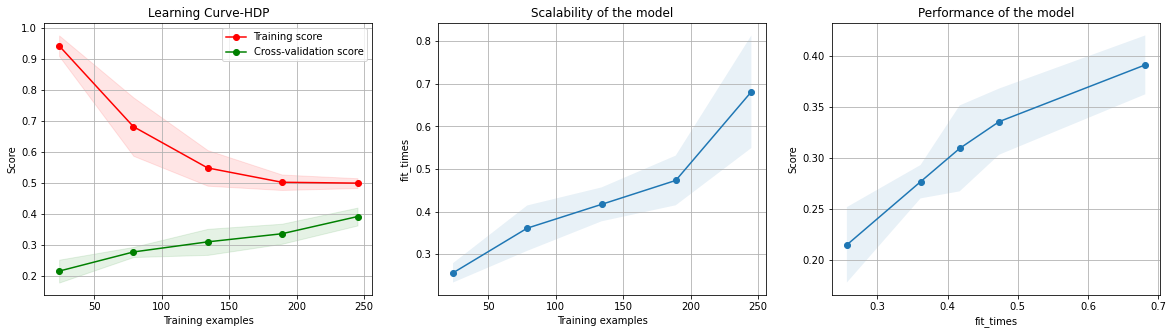

In [44]:
plot_learning_curve(NNmodel, "Learning Curve-HDP", X, y, n_jobs=4)

plt.show()

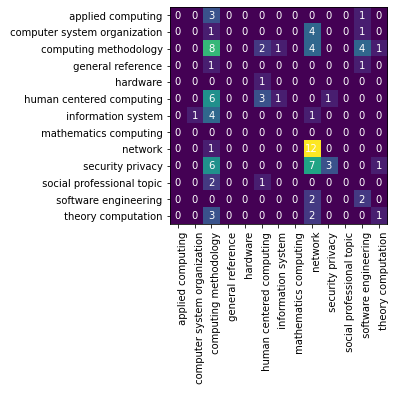

<Figure size 432x288 with 0 Axes>

In [45]:
cm = confusion_matrix(y_test3, y_pred, labels=NNmodel.classes_)
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(len(NNmodel.classes_)))
ax.set_yticks(np.arange(len(NNmodel.classes_)))
ax.set_xticklabels(NNmodel.classes_)
ax.set_yticklabels(NNmodel.classes_)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
for i in range(len(NNmodel.classes_)):
    for j in range(len(NNmodel.classes_)):
        text = ax.text(j, i, cm[i,j],
                       ha="center", va="center", color="w")
plt.show()
plt.savefig('HDP.png')

## Combining models based on Probabilities

In [46]:
model1 = pickle.load(open(TASK1_TFIDF, 'rb'))
model2 = pickle.load(open(TASK1_LDA, 'rb'))
model3 = pickle.load(open(TASK1_HDP, 'rb'))

prediction1_prob = model1.predict_proba(x_test1)
prediction2_prob = model2.predict_proba(x_test2)
prediction3_prob = model3.predict_proba(x_test3)


classes = model1.classes_

y_pred = []
for i in range(len(prediction1_prob)):
    max_probs = list(np.maximum(prediction1_prob[i],prediction2_prob[i],prediction3_prob[i]))
    index = max_probs.index(max(max_probs))
    y_pred.append(classes[index])

cmtx = pd.DataFrame(
    confusion_matrix(y_test1, y_pred, labels=NNmodel.classes_), 
    index=NNmodel.classes_, 
)
print(cmtx)
print("Accuracy: ",accuracy_score(y_test1, y_pred, normalize=False)," out of ",len(y_test1))
print("Precision: ",precision_score(y_test1, y_pred, zero_division=1, average='macro'))
print("Recall: ",recall_score(y_test1, y_pred,zero_division=1, average='macro'))
print("F1: ",f1_score(y_test1, y_pred, zero_division=1,average='macro'))

                               0  1  2  3  4  5  6  7   8  9  10  11  12
 applied computing             0  0  1  0  0  1  1  0   0  0   0   0   1
 computer system organization  0  1  1  0  0  0  0  1   2  0   0   1   0
 computing methodology         1  0  5  0  0  4  0  2   2  1   1   2   2
 general reference             0  0  0  0  0  1  0  1   0  0   0   0   0
 hardware                      0  0  1  0  0  0  0  0   0  0   0   0   0
 human centered computing      0  0  1  0  0  8  0  0   0  1   0   0   1
 information system            0  0  0  0  0  0  3  0   0  1   0   1   1
 mathematics computing         0  0  0  0  0  0  0  0   0  0   0   0   0
 network                       0  1  0  0  0  0  0  0  11  1   0   0   0
 security privacy              0  0  1  0  0  2  1  2   0  7   2   1   1
 social professional topic     0  0  1  0  0  2  0  0   0  0   0   0   0
 software engineering          0  0  1  0  0  1  0  0   1  0   0   1   0
 theory computation            0  0  1  0  0  0  0 

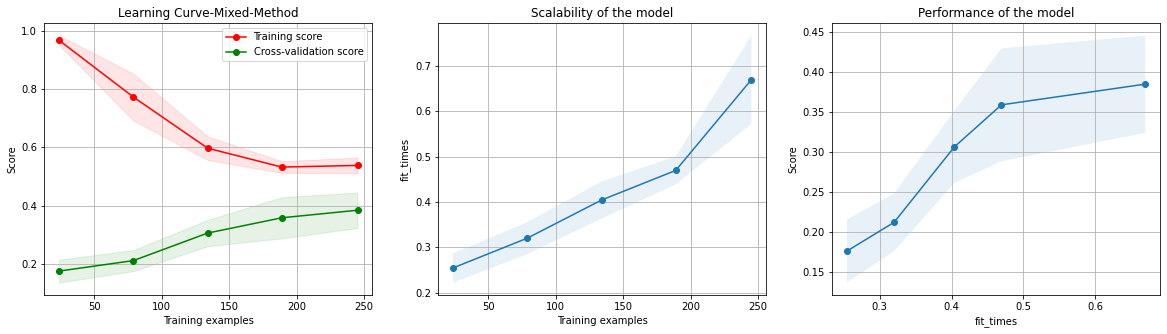

In [353]:
plot_learning_curve(NNmodel, "Learning Curve-Mixed-Method", X, y, n_jobs=4)

plt.show()

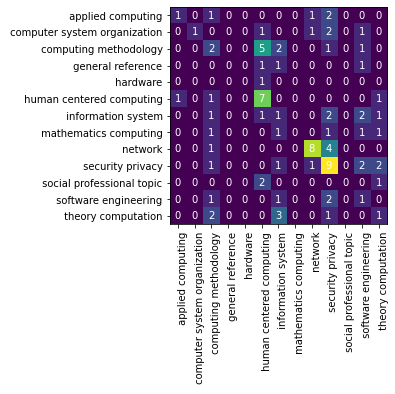

In [358]:
cm = confusion_matrix(y_test1, y_pred, labels=NNmodel.classes_)
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(len(NNmodel.classes_)))
ax.set_yticks(np.arange(len(NNmodel.classes_)))
ax.set_xticklabels(NNmodel.classes_)
ax.set_yticklabels(NNmodel.classes_)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
for i in range(len(NNmodel.classes_)):
    for j in range(len(NNmodel.classes_)):
        text = ax.text(j, i, cm[i,j],
                       ha="center", va="center", color="w")

## Using PyTorch NN
Takes a lot of time to run even with 8 cores


In [ ]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#       # First fully connected layer
#         self.fc1 = nn.Linear(67531, 77531)
#       # Second fully connected layer that outputs our 10 labels
#         self.fc2 = nn.Linear(77531, 60000)
#         self.fc3 = nn.Linear(60000, 50000)
#         self.fc4 = nn.Linear(50000, 40000)
#         self.fc5 = nn.Linear(40000, 20000)
#         self.fc6 = nn.Linear(20000, 10000)
#         self.fc7 = nn.Linear(10000, 1000)
#         self.fc8 = nn.Linear(1000, 512)
#         self.fc9 = nn.Linear(512, y_value_types)
        
        
#     def forward(self, x):

#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = self.fc3(x)
#         x = F.relu(x)
#         x = self.fc4(x)
#         x = F.relu(x)
#         x = self.fc5(x)
#         x = F.relu(x)
#         x = self.fc6(x)
#         x = F.relu(x)
#         x = self.fc7(x)
#         x = F.relu(x)
#         x = self.fc8(x)
#         x = F.relu(x)
#         x = self.fc9(x)


#       # Apply softmax to x
#         output = F.log_softmax(x, dim=1)
#         return output

# my_nn = Net()
# print(my_nn)

In [ ]:
# Criteria = nn.CrossEntropyLoss()
# optimizer = optim.SGD(Net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# dtype = torch.float
# device = torch.device("cpu")

# x_train = torch.FloatTensor(x_train2)
# y_train = torch.FloatTensor(y_train2)

# learning_rate = 1e-3
# for t in range(500):
    
#     y_pred = Net (x_train)
#     optimizer.zero_grad()
    
#     loss = Criteria(y_pred, y_train)
#     running_loss += loss.item()
    
#     loss.backward()
#     optimizer.step()

# 2. Finding and Predicting Subcommitees

In [237]:
path = os.getcwd()+"/papers/CHI"

In [238]:
CHI_files = [f for f in listdir(path) if isfile(join(path, f))]
print("Total number of papers:", len(CHI_files))

Total number of papers: 2565


Uncomment for reading files: Estimated time to process is 15 minutes on 4 cores. Pickled text files containing the output are already placed in the current working directory. Please skip this cell.

In [239]:
# CHI_papers = []
# counter = 0
# pbar = ProgressBar()
# for i in pbar(CHI_files):
#     addr = path+"/"+i
#     if addr[-3:]=="pdf":
#         with open(addr, "rb") as f:
#             pdf = pdftotext.PDF(f)
#             text = ("\n".join(pdf)).split("\n")
#             CHI_papers.append("\n".join(pdf))

100% |########################################################################|


Uncomment for reading files: Estimated time to process is 12 minutes on 4 cores. Pickled text files containing the output are already placed in the current working directory. 

In [243]:
# with open("CHI_papers_text.txt", "wb") as fp:
#     pickle.dump(CHI_papers, fp)
    
with open("CHI_papers_text.txt", "rb") as fp:   # Unpickling
    CHI_papers = pickle.load(fp)

In [242]:
# words = []
# pbar = ProgressBar()
# for i in pbar(CHI_papers):
#     words.append(word_tokenize(preprocess(i)))

100% |########################################################################|


In [244]:
# with open("CHI_papers_words.txt", "wb") as fp:
#     pickle.dump(words, fp)
    
with open("CHI_papers_words.txt", "rb") as fp:   # Unpickling
    words = pickle.load(fp)

Experimenting with different number of topics

In [245]:
perplexity_array = []
coherence_lda_array = []
art_num = 0


for i in range(3,20):
    TOPIC_NUM  = i
    LDA = 'Project.%03d.lda' % TOPIC_NUM
    dictionary = Dictionary(words)
    dictionary.filter_extremes(no_below=2)
    dictionary.filter_extremes(no_above = 0.9)
    dictionary.save('PS3.bow.dict')
    bow_corpus = [ dictionary.doc2bow(t) for t in words ]
    MmCorpus.serialize('PS3.bow.mm', bow_corpus)
    size = int(len(bow_corpus) * 9 / 10)
    training = bow_corpus[:size]
    testing = bow_corpus[size:]
    hdp = HdpModel(training, dictionary)
    lda = LdaModel(training, id2word=dictionary, num_topics=TOPIC_NUM, passes=5)
    lda.save(LDA)
    perplexity = 2 ** -(lda.log_perplexity(testing))
    perplexity_array.append(perplexity)
    cm = CoherenceModel(model=lda, corpus=training, coherence='u_mass')        
    coherence_lda = cm.get_coherence()
    coherence_lda_array.append(coherence_lda)

Finding Perplexity and coherence scores against different number of topics

In [246]:
x = list(range(3,20))
perplexity_scores = perplexity_array
coherence_scores = coherence_lda_array

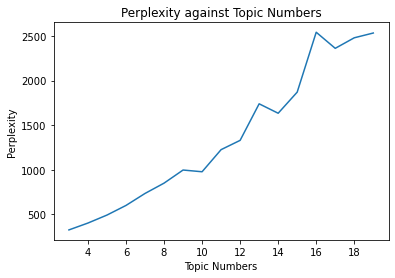

In [247]:
plt.plot(x, perplexity_scores) 
plt.xlabel('Topic Numbers') 
plt.ylabel('Perplexity') 
plt.title('Perplexity against Topic Numbers') 
plt.show() 

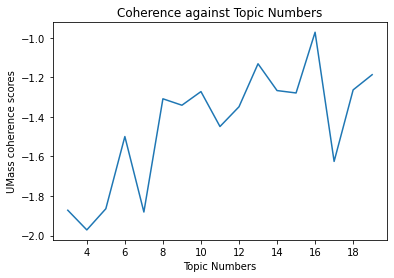

In [249]:
plt.plot(x, coherence_scores) 
plt.xlabel('Topic Numbers') 
plt.ylabel('UMass coherence scores') 
plt.title('Coherence against Topic Numbers') 
plt.show() 

LDA topic map

In [250]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, training, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.080064 -0.000298       1        1  22.199896
12     0.084580  0.029086       2        1  10.547183
14     0.080989 -0.103341       3        1   8.171375
10    -0.134895  0.012457       4        1   7.587554
17    -0.109824  0.285353       5        1   7.152856
1     -0.099775 -0.059488       6        1   7.016406
3      0.163001  0.025235       7        1   6.962351
9     -0.082314 -0.004192       8        1   6.639438
6      0.082768 -0.001093       9        1   6.551944
13     0.162567 -0.033036      10        1   6.533525
4     -0.224532 -0.111694      11        1   5.027716
11    -0.111012 -0.082244      12        1   2.808025
15     0.020312  0.068014      13        1   2.774556
2     -0.009693  0.080077      14        1   0.004529
18     0.027318  0.002642      15        1   0.004529
5      0.033043 -0.023088      16        1   0.004529
7      0.020369 -0.000533      17        1   0.004529
8     -0.001344 -0.073421      18        1   0.004529
0      0.018378 -0.010435      19        1   0.004529, topic_info=           Term        Freq       Total Category  logprob  loglift
1152      chart  194.000000  194.000000  Default  30.0000  30.0000
412      series  136.000000  136.000000  Default  29.0000  29.0000
632         iot  104.000000  104.000000  Default  28.0000  28.0000
1132      woman  182.000000  182.000000  Default  27.0000  27.0000
1218    patient  196.000000  196.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
997   selection    0.001735   87.861603  Topic19  -6.3016  -0.8298
495       child    0.001757  109.834923  Topic19  -6.2892  -1.0406
1218    patient    0.001827  196.136536  Topic19  -6.2504  -1.5817
691       photo    0.001606   69.966682  Topic19  -6.3792  -0.6798
769        site    0.001596   62.273594  Topic19  -6.3855  -0.5696

[1058 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1259      6  0.230045   13th
1259     11  0.230045   13th
1259     12  0.460091   13th
1309      1  0.188081   17th
1309      3  0.188081   17th
...     ...       ...    ...
838       5  0.284284  worth
838      10  0.284284  worth
1258      1  0.163165  wrong
1258      2  0.489494  wrong
1258      9  0.163165  wrong

[2603 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 13, 15, 11, 18, 2, 4, 10, 7, 14, 5, 12, 16, 3, 19, 6, 8, 9, 1])

HDP topic map

In [251]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(hdp, training, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster          Freq
topic                                                   
0     -0.084060 -0.049287       1        1  1.062849e+01
1      0.116922  0.030812       2        1  9.050446e+00
2      0.007998 -0.013674       3        1  8.807843e+00
3     -0.040521  0.077010       4        1  7.932469e+00
5     -0.078015 -0.012156       5        1  7.235055e+00
...         ...       ...     ...      ...           ...
145    0.005884 -0.004270     146        1  4.266577e-44
146   -0.013266  0.009244     147        1  2.133289e-44
147    0.002665  0.007205     148        1  1.066644e-44
148   -0.017399  0.011246     149        1  5.333221e-45
149    0.007855  0.000276     150        1  5.333221e-45

[150 rows x 5 columns], topic_info=          Term          Freq       Total  Category  logprob  loglift
1132     woman  1.430000e+02  143.000000   Default  30.0000  30.0000
1218   patient  1.490000e+02  149.000000   Default  29.0000  29.0000
1152     chart  1.340000e+02  134.000000   Default  28.0000  28.0000
823    virtual  1.090000e+02  109.000000   Default  27.0000  27.0000
632        iot  7.900000e+01   79.000000   Default  26.0000  26.0000
...        ...           ...         ...       ...      ...      ...
785      steve  3.295244e-45   14.270437  Topic150  -5.8238   1.4655
1017      tive  3.143497e-45   12.879839  Topic150  -5.8710   1.5209
953    matthew  3.124031e-45   13.447925  Topic150  -5.8772   1.4715
995   scenario  3.428917e-45   30.024960  Topic150  -5.7840   0.7614
1250     topic  3.255124e-45   86.657103  Topic150  -5.8361  -0.3505

[6747 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.302021    05…
0         2  0.151010    05…
0         3  0.302021    05…
0         5  0.151010    05…
0        12  0.151010    05…
...     ...       ...    ...
1036      4  0.116095  zhang
1036      8  0.116095  zhang
1036      9  0.116095  zhang
1036     11  0.116095  zhang
1036     13  0.116095  zhang

[10218 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 6, 5, 7, 9, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150])

Running LDA again with 16 topics based on coherence and perplexity scores.

In [259]:
TOPIC_NUM  = 12
LDA = 'Project.%03d.lda' % TOPIC_NUM
dictionary = Dictionary(words)
dictionary.filter_extremes(no_below=2)
dictionary.filter_extremes(no_above = 0.9)
dictionary.save('PS3.bow.dict')
bow_corpus = [ dictionary.doc2bow(t) for t in words ]
MmCorpus.serialize('PS3.bow.mm', bow_corpus)
size = int(len(bow_corpus) * 9 / 10)
training = bow_corpus[:size]
testing = bow_corpus[size:]
hdp = HdpModel(training, dictionary)
lda = LdaModel(training, id2word=dictionary, num_topics=TOPIC_NUM, passes=5)
lda.save(LDA)
perplexity = 2 ** -(lda.log_perplexity(testing))
perplexity_array.append(perplexity)
cm = CoherenceModel(model=lda, corpus=training, coherence='u_mass')        
coherence_lda = cm.get_coherence()
coherence_lda_array.append(coherence_lda)

In [260]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, training, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.077429 -0.003610       1        1  21.815231
9     -0.169303  0.034501       2        1  12.665409
0      0.100738  0.054105       3        1  11.895467
8      0.100807 -0.113624       4        1  10.763298
1     -0.205808 -0.052354       5        1   9.552633
7      0.084073  0.013912       6        1   8.798546
10     0.028830 -0.146570       7        1   7.702218
5     -0.027288 -0.035916       8        1   7.509543
11     0.002193  0.171479       9        1   6.815787
6      0.024618  0.102720      10        1   2.467523
3     -0.042154 -0.017026      11        1   0.007171
2      0.025865 -0.007619      12        1   0.007171, topic_info=           Term        Freq       Total Category  logprob  loglift
1218    patient  203.000000  203.000000  Default  30.0000  30.0000
823     virtual  152.000000  152.000000  Default  29.0000  29.0000
1152      chart  159.000000  159.000000  Default  28.0000  28.0000
1132      woman  186.000000  186.000000  Default  27.0000  27.0000
1031    walking   92.000000   92.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
321     gesture    0.003051   67.154282  Topic12  -6.1970  -0.4565
79      element    0.002979   73.005157  Topic12  -6.2206  -0.5636
1361       team    0.002641   41.232323  Topic12  -6.3411  -0.1128
681       older    0.002748   55.377014  Topic12  -6.3016  -0.3683
590   framework    0.002603   46.092297  Topic12  -6.3558  -0.2390

[652 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1262      2  0.105523   19th
1262      4  0.105523   19th
1262      5  0.105523   19th
1262      6  0.422091   19th
1262      9  0.105523   19th
...     ...       ...    ...
1257      1  0.131025   worn
1257      2  0.131025   worn
1257      5  0.655123   worn
838       5  0.301005  worth
838       8  0.602010  worth

[2131 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 1, 9, 2, 8, 11, 6, 12, 7, 4, 3])

## Human Supervision

Topic 1 = 'Policy'
Topic 2 = 'AR/VR'
Topic 3 = 'Internet of Things'
Topic 4 = 'Health'
Topic 5 = 'Multi-modality'
Topic 6 = 'ICT4D'
Topic 7 = 'Gender'
Topic 8 = 'Visualization'
Topic 9 = 'Game'
Topic 10 = 'Cognition'
Topic 11 = 'AR/VR'
Topic 12 = 'Health'

In [266]:
topic_array = ['Policy','AR/VR','Internet of Things', 'Health','HCI experiment','ICT4D','Gender','Visualization','Game','Cognition','AR/VR','Health']

In [267]:
path = os.getcwd()+"/papers/test"

In [268]:
test_files = [f for f in listdir(path) if isfile(join(path, f))]
print("Total number of papers:", len(test_files))

Total number of papers: 11


In [286]:
for i in (test_files):
    addr = path+"/"+i
    if addr[-3:]=="pdf":
        with open(addr, "rb") as f:
            pdf = pdftotext.PDF(f)
            text = ("\n".join(pdf)).split("\n")
            print("Title: ",''.join(preprocess(text[5:7])),"...")
            paper = "\n".join(pdf)
            toks = (word_tokenize(preprocess(paper)))
            bow_corpus = dictionary.doc2bow(toks)
            new_hdp = (lda[bow_corpus])
            new_hdp.sort(key=lambda x:x[1])
            primary_topic = new_hdp[-1][0]
            secondary_topic = new_hdp[-2][0]
            tertiary_topic = new_hdp[-3][0]
            print("Topics: ",topic_array[primary_topic],topic_array[secondary_topic],topic_array[tertiary_topic])

Title:   verified make credible account verification efect tweet credibility ...
Topics:  HCI experiment Game Policy
Title:   matter studying impact relationship characteristic receptivity ...
Topics:  HCI experiment Game Cognition
Title:   geppeto enabling semantic design expressive robot behavior ...
Topics:  HCI experiment Cognition Health
Title:   missing role instructional design child game based learning ...
Topics:  HCI experiment Health Visualization
Title:   bought look ordinary study blind people online shopping ...
Topics:  HCI experiment Cognition Policy
Title:   exploring factor influence connected driver 'to use follow recommended optimal route ...
Topics:  HCI experiment AR/VR Visualization
Title:   interstice sustained spatial relationship hand surface reveal anticipated action ...
Topics:  Cognition AR/VR HCI experiment
Title:   vulnerability blame making sense unauthorized access smartphones ...
Topics:  HCI experiment Game Health
Title:   personal health oracle explo